In [1]:
#Prerequisite Libraries
import time
import pyvisa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import psutil

Sample Code for the NMR and Scope Control

The central libary for communication with the AWG and scope is pyvisa. This eis used to establish a connection to the device through which you can send a number of commands. The full list of commands can be found in the manuals for the AWG or scope.
In order to begin communication, we need the device address. 

In [2]:
AWG_ID = 'USB0::0x0957::0x5707::MY59002119::0::INSTR'
SCOPE_ID = 'USB0::0x0699::0x0401::B020014::0::INSTR'

We then open a connection to the two devices. 

In [3]:
rm = pyvisa.ResourceManager()

rm.list_resources()


('USB0::0x0699::0x0401::B020014::0::INSTR',
 'USB0::0x0957::0x5707::MY59001893::0::INSTR',
 'USB0::0x0957::0x5707::MY59002119::0::INSTR',
 'TCPIP0::128.112.50.11::inst0::INSTR',
 'ASRL3::INSTR')

In [4]:
awg = rm.open_resource(AWG_ID)
scope = rm.open_resource(SCOPE_ID)

In [5]:
print(awg.query("*IDN?"))
print(scope.query("*IDN?"))

Agilent Technologies,33622A,MY59002119,A.02.03-3.15-03-64-02

TEKTRONIX,DPO4034,B020014,CF:91.1CT FV:v2.06 



We need some basic parameters from the AWG. 

In [6]:
SAMPLE_RATE = 1e8 #per sec #Sample rate of the AWG
MAX = 32767 #Corresponds to the max amplitude of the pulse in binary bits (Note: this is not the pulse amplitude in terms of voltage,
#but the relative value for the DAC) If you set a pulse height to this value, then that pulse with have the full amplitude of whatever you set your voltage to in the output)

The basic structure of using the AWG to write arbitary waveforms is to specify individual parts of a sequence, such as pulse A, delay A, pulse B, delay B, etc. Each components is stored in the AWG memory under an associated name, and then segments can be strung together to form a sequence. 

In [7]:
# Beginning of AWG communication:

awg.write("*CLS") #Clears the AWG status
awg.write("*RST") #Resets the AWG 


awg.write('FORMat:BORDer SWAP') #Specifies binary block reading order. See manual if curious
awg.write('TRIG1:SOUR EXT') #Sets the trigger for channel one to the external source.
awg.write('SOUR1:FUNC ARB') #Sets the AWG to an as of yet unspecified arbitary output

awg.write(f'SOUR1:FUNC:ARB:SRAT {SAMPLE_RATE*2:.0E}') #Set the sample rate of source 1 of the AWG (nominally set by the hardware)

awg.write('TRIG2:SOUR EXT') #Sets the trigger for channel two to the external source.
awg.write('SOUR2:FUNC ARB') #Sets the AWG to an as of yet unspecified arbitary output

awg.write(f'SOUR2:FUNC:ARB:SRAT {SAMPLE_RATE*2:.0E}') #Set the sample rate of source 2 of the AWG (nominally set by the hardware)

27

In [8]:
def trace(wait_duration=5):
    scope.write('data:source CH1')

    vscale = float(scope.query('wfmoutpre:ymult?'))
    voff = float(scope.query('wfmoutpre:yzero?'))
    vpos = float(scope.query('wfmoutpre:yoff?'))

    record = int(scope.query('horizontal:recordlength?'))
    tscale = float(scope.query('wfmoutpre:xincr?'))
    tstart = float(scope.query('wfmoutpre:xzero?'))

    total_time = tscale * record
    tstop = tstart + total_time
    times = np.linspace(tstart, tstop, num=record, endpoint=False)

    time.sleep(wait_duration)

    waveform = scope.query_binary_values('curve?', datatype='b', container=np.array)
    waveform = (waveform - vpos) * vscale + voff

    return times, waveform

RABI Experiment:

In [9]:
def rabi_pulse(t):
    pulse_samples = t * SAMPLE_RATE

    pulse_binary =  np.ones(int(pulse_samples), dtype=int) * MAX
    # print(pulse_binary)

    awg.write("SOUR1:DATA:VOL:CLE")

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PULSE, ', 
        pulse_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        np.zeros(int(400), dtype=int) * MAX, 
        datatype='i')
    
    sequence_command = f'RABI,PULSE,0,once,highAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'

    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB RABI')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')


rabi_pulse(3.5753898459990127e-06)

In [50]:
def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e6
    return amp_integral

rabi_pulse(3.5753898459990127e-06) #initial estimate of pi/2 length
x,y = trace(2)
normalization_const = integral(x,y)
normalization_const

119484.0000000074

Pulse Time 0.5us, area under curve is 69984.0000000061 V*us
Pulse Time 0.5943775100401606us, area under curve is 73220.00000000633 V*us
Pulse Time 0.6887550200803212us, area under curve is 74492.00000000632 V*us
Pulse Time 0.783132530120482us, area under curve is 81016.00000000809 V*us
Pulse Time 0.8775100401606426us, area under curve is 81020.00000000796 V*us
Pulse Time 0.9718875502008032us, area under curve is 85544.00000000915 V*us
Pulse Time 1.0662650602409638us, area under curve is 88552.00000000985 V*us
Pulse Time 1.1606425702811245us, area under curve is 90704.00000001035 V*us
Pulse Time 1.2550200803212852us, area under curve is 91964.00000000943 V*us
Pulse Time 1.3493975903614457us, area under curve is 95332.0000000091 V*us
Pulse Time 1.4437751004016064us, area under curve is 98608.00000000834 V*us
Pulse Time 1.5381526104417673us, area under curve is 101168.0000000087 V*us
Pulse Time 1.6325301204819278us, area under curve is 104460.00000000883 V*us
Pulse Time 1.7269076305220885

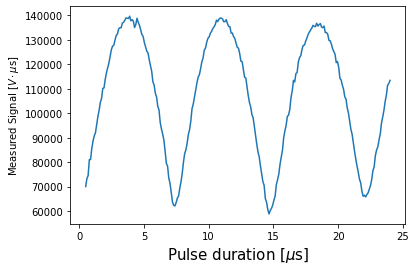

In [10]:
min_t = 5e-7
max_t = 24e-6
num = 250
arr = np.linspace(min_t,max_t,num)
rabi_times = arr*1e6

delay_time = 2.5

amps = []

def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e6
    return amp_integral


for t in arr:
    rabi_pulse(t)
    x,y = trace(delay_time)
    amp = integral(x,y)
    amps.append(amp)
    print(f"Pulse Time {t*1e6}us, area under curve is {amp} V*us")

plt.xlabel('Pulse duration [$\mu$s]', fontsize = 15)
plt.ylabel('Measured Signal [$V\cdot \mu$s]')
plt.plot(rabi_times, amps)



In [11]:
f = open('data_newfinal_rabi.txt', 'w')
for i in range(len(rabi_times)):
    f.write(str(rabi_times[i])+','+str(amps[i])+'\n')
f.close()
#drift from 21.37134MHz to 21.37134MHz

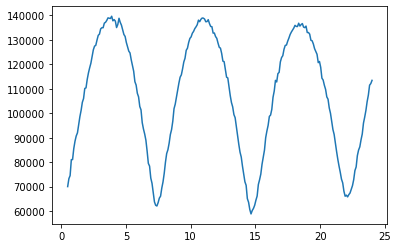

In [12]:
f = pd.read_csv('data_newfinal_rabi.txt', header=None, names=["durations", 'amps', 'y2'])


rabi_times = f.durations
rabi_amps = f.amps
# rabi_amps /=  normalization_const
# rabi_amps -= np.min(rabi_amps)
plt.plot(rabi_times, rabi_amps)

In [19]:
#fit functions

def sinusoid(x, A, T, phase, offset):
    return A*np.abs(np.cos((2*np.pi/T)*x + phase)) + offset

def exp_decay(t, A, decay, offset):
    return A*np.exp(-t/decay) + offset

def exp_osc(x, A, decay, T,phase,offset):
    return np.exp(-x/decay)*(A*np.abs(np.cos((2*np.pi/T)*x + phase))) + offset



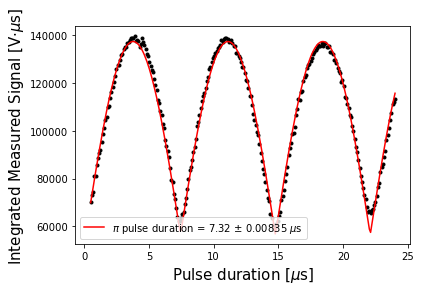

In [20]:
fit, err = curve_fit(exp_osc, rabi_times, rabi_amps, p0 = [60000, 100, 12, 0, 60000])
plt.scatter(rabi_times, rabi_amps, c = 'black', marker = '.')
plt.xlabel('Pulse duration [$\mu$s]', fontsize = 15)
plt.ylabel('Integrated Measured Signal [V$\cdot\mu$s]', fontsize = 15)
plt.plot(rabi_times, exp_osc(rabi_times, *fit), c = 'red', label = f'$\pi$ pulse duration = {fit[2]/2:.2f} $\pm$ {round(np.sqrt(err[2,2]/2),5)} $\mu$s')
plt.legend()
plt.show()

In [21]:
pi_time = fit[2]
pi_time_err = np.sqrt(err[2,2])
pi_2_time = pi_time/2
pi_2_time_err = np.sqrt(err[2,2]/2)

print('Pi Pulse Duration: %.2f +- %.1e us' % (pi_time, pi_time_err))
print('Pi/2 Pulse Duration: %.2f +- %.1e us' % (pi_2_time, pi_2_time_err))

Pi Pulse Duration: 14.65 +- 1.2e-02 us
Pi/2 Pulse Duration: 7.32 +- 8.3e-03 us


In [22]:
pi_duration = pi_time*1e-6
pi2_duration = pi_2_time*1e-6
pi_duration /= 2
pi2_duration /= 2

In [23]:
print(pi2_duration)
print(pi_duration)

3.6621855218958675e-06
7.324371043791735e-06


In [18]:
def mem_check():
    print(f"CPU utilization: {psutil.cpu_percent()}%") 
    print(f"Memory utilization: {psutil.virtual_memory().percent}%")
    if (psutil.cpu_percent() > 95):
        raise Exception("CPU overflowing")
    if (psutil.virtual_memory().percent > 95):
        raise Exception("Virtual memory overflowing")

T2* Experiment:

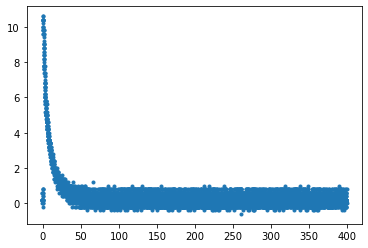

In [64]:
def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e3
    return amp_integral

rabi_pulse(pi2_duration)
x,y = trace(2)
normalization_const = max(y)
x = x*1e3
plt.scatter(x,y , marker = '.')

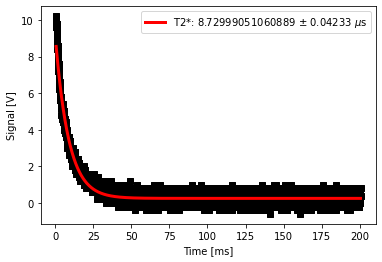

In [26]:
fit, err = curve_fit(exp_decay,x, y, p0 = [10, 10, 0])
plt.plot(x, exp_decay(x, *fit), c = 'red', linewidth = 3, label = f'T2*: {fit[1]} $\pm$ {round(np.sqrt(err[1,1]), 5)} $\mu$s')
plt.scatter(x,y, marker = ',', c = 'black')
plt.xlabel('Time [ms]')
plt.ylabel('Signal [V]')
plt.legend()
plt.show()

In [31]:
print(fit[1])

8.72999051060889


In [29]:
f = open('data_FID.txt', 'w')
for i in range(len(x)):
    f.write(str(x[i])+','+str(y[i])+'\n')
f.close()

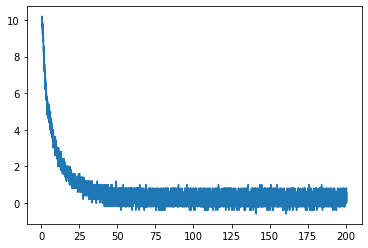

In [30]:
f = pd.read_csv('data_FID.txt', header=None, names=["durations", 'amps', 'y2'])
ramsey_times = f.durations
ramsey_amps = f.amps
# rabi_amps /=  normalization_const
# rabi_amps -= np.min(rabi_amps)
plt.plot(ramsey_times, ramsey_amps)

In [32]:
#T1 Experiment

def t1_exp(pi2_pulse, pi_pulse, tau):   
    # print('defining samples and binary')
    pi2_pulse_samples = int(pi2_pulse * SAMPLE_RATE)
    pi_pulse_samples = int(pi_pulse * SAMPLE_RATE)

    delay_nums = 100
    delay_unit = tau / delay_nums
    delay_unit_samples = int(delay_unit * SAMPLE_RATE)

    pi2_binary = np.ones(pi2_pulse_samples, dtype = int) * MAX
    pi_binary = np.ones(pi_pulse_samples, dtype = int) * MAX
    delay_binary = np.zeros(delay_unit_samples, dtype=int)
    # print('done')

    # print('Clearing volatile memory on AWG')
    awg.write("SOUR1:DATA:VOL:CLE")
    # print('done')

    # print('Writing Pi2_PULSE binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI2_PULSE, ', 
        pi2_binary, 
        datatype='i')
    # print('Done')

    # print('Writing Delay binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        delay_binary, 
        datatype='i')
    # print('done')

    # print('Writing Pi Pulse Binary')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_PULSE, ', 
        pi_binary, 
        datatype='i')
    # print('Done')
    
    sequence_command = f'T1,PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,PI2_PULSE,0,once,highAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'


    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    # print('Writing Sequence Command to AWG')
    awg.write(full_sequence_command)
    # print('Done')

    # print('Writing Voltage Amplitude and turning on outputs')
    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB T1')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')
    awg.write('OUTP2 OFF')
    # print('done')



Delay 1.0ms, area under the spin signal is 129.22000000001623
Delay 1.3975903614457832ms, area under the spin signal is 129.3320000000164
Delay 1.7951807228915664ms, area under the spin signal is 130.77200000001412
Delay 2.192771084337349ms, area under the spin signal is 128.59200000001766
Delay 2.5903614457831328ms, area under the spin signal is 128.460000000018
Delay 2.9879518072289155ms, area under the spin signal is 129.55600000001655
Delay 3.3855421686746987ms, area under the spin signal is 128.532000000018
Delay 3.783132530120482ms, area under the spin signal is 128.08000000001806
Delay 4.180722891566265ms, area under the spin signal is 129.9400000000157
Delay 4.578313253012048ms, area under the spin signal is 128.30800000001764
Delay 4.975903614457831ms, area under the spin signal is 127.20000000001792
Delay 5.373493975903615ms, area under the spin signal is 128.54000000001804
Delay 5.771084337349397ms, area under the spin signal is 128.70800000001609
Delay 6.168674698795181ms, 

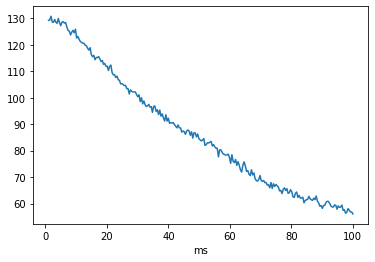

In [33]:
min_t = 1e-3
max_t = 100e-3
num = 250
arr = np.linspace(min_t,max_t,num)
t1_times = arr*1e3
delay_time = 2.5

t1_amps = []

def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e3
    return amp_integral


for tau in arr:
    t1_exp(pi2_duration, pi_duration, tau)
    x,y = trace(delay_time)
    amp = integral(x,y)
    t1_amps.append(amp)
    print(f"Delay {tau*1e3}ms, area under the spin signal is {amp}")

plt.xlabel('ms')
plt.plot(t1_times, t1_amps)


# trace(3)


In [73]:
rabi_pulse(pi2_duration)

In [65]:
normalization_const

10.600000000000001

In [37]:
t1_f = open('t1_Final.txt', 'w')
for i in range(len(t1_times)):
    t1_f.write(str(t1_times[i])+','+str(t1_amps[i])+'\n')
t1_f.close()
 #drift from 21.37134MHz to 21.37130MHz
 #drift from 21.37176MHz to 21.37168MHz

0        1.000000
1        1.397590
2        1.795181
3        2.192771
4        2.590361
          ...    
245     98.409639
246     98.807229
247     99.204819
248     99.602410
249    100.000000
Name: delays, Length: 250, dtype: float64


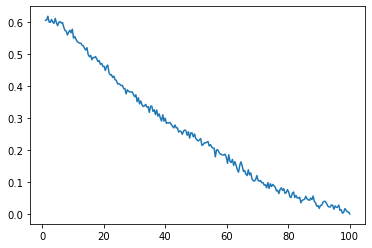

In [38]:
t1_f = pd.read_csv('t1_Final.txt', header=None, names=["delays", 'amps', 'y2'])

t1_finaltimes = t1_f.delays
t1_amps = t1_f.amps/normalization_const 
t1_finalamps = t1_amps - np.min(t1_amps)
print(t1_finaltimes)

plt.plot(t1_finaltimes, t1_finalamps)

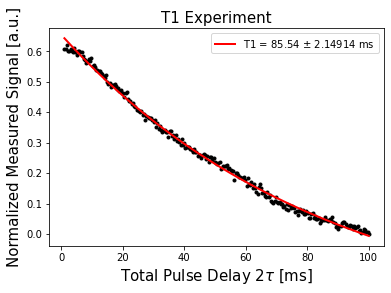

In [39]:
fit, err = curve_fit(exp_decay, t1_finaltimes, t1_finalamps, p0 = [1, 80, 0.5])
plt.scatter(t1_finaltimes, t1_finalamps, c= 'black', marker = '.')
plt.xlabel(f'Total Pulse Delay $2\\tau$ [ms]', fontsize = 15)
plt.ylabel('Normalized Measured Signal [a.u.]', fontsize = 15)
plt.plot(t1_finaltimes, exp_decay(t1_finaltimes, *fit), linewidth = 2, c = 'red', label = f'T1 = {fit[1]:.2f} $\pm$ {round(np.sqrt(err[1,1]),5)} ms')
plt.legend()
plt.title('T1 Experiment', fontsize = 15)
plt.show()

In [40]:
print('T1 Relaxation time: %.2f +- %.1e ms' % (fit[1], np.sqrt(err[1,1]))) #should be ~90ms

T1 Relaxation time: 85.54 +- 2.1e+00 ms


Hahn Echo Experiment:

In [41]:
def hahn_exp(pi2_pulse, pi_pulse, tau):
    # print('defining samples and binary')
    pi2_pulse_samples = int(pi2_pulse * SAMPLE_RATE)
    pi_pulse_samples = int(pi_pulse * SAMPLE_RATE)

    delay_nums = 100
    delay_unit = tau / delay_nums
    delay_unit_samples = int(delay_unit * SAMPLE_RATE)

    pi2_binary = np.ones(pi2_pulse_samples, dtype = int) * MAX
    pi_binary = np.ones(pi_pulse_samples, dtype = int) * MAX
    delay_binary = np.zeros(delay_unit_samples, dtype=int)
    # print('done')

    # print('Clearing volatile memory on AWG')
    awg.write("SOUR1:DATA:VOL:CLE")
    # print('done')

    # print('Writing Pi2_PULSE binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI2_PULSE, ', 
        pi2_binary, 
        datatype='i')
    # print('Done')

    # print('Writing Delay binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        delay_binary, 
        datatype='i')
    # print('done')

    # print('Writing Pi Pulse Binary')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_PULSE, ', 
        pi_binary, 
        datatype='i')
    # print('Done')
    
    sequence_command = f'HAHN,PI2_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'

    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB HAHN')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')


In [42]:
def echo_amplitude(x, y, tau, num_pulses):
    for time in range(len(x)):
        if x[time] >= num_pulses*tau:
            # print(f'{time, x[time]*1e3} ms')
            return np.max(y[2*time-10:])

In [43]:
hahn_exp(pi2_duration, pi_duration, 18e-3)
x,y = trace(3)
print(echo_amplitude(x,y,18e-3,1))
print()
for amp in range(len(y)):
    print(x[amp]*1e3, y[amp])

7.800000000000001

0.6 9.8
0.62 9.600000000000001
0.6399999999999999 9.8
0.66 9.8
0.6799999999999999 9.8
0.7 9.4
0.72 9.8
0.74 9.8
0.7599999999999999 9.8
0.78 9.600000000000001
0.7999999999999999 9.600000000000001
0.82 9.600000000000001
0.8400000000000001 9.4
0.86 9.200000000000001
0.8799999999999999 9.4
0.9 9.8
0.92 9.4
0.94 9.0
0.96 9.8
0.98 9.0
1.0 9.200000000000001
1.02 9.0
1.0399999999999998 9.0
1.06 9.0
1.08 9.200000000000001
1.0999999999999999 9.0
1.1199999999999999 8.8
1.14 8.8
1.16 9.200000000000001
1.1800000000000002 8.8
1.2000000000000002 8.8
1.22 9.200000000000001
1.24 9.0
1.26 8.8
1.2799999999999998 9.0
1.3 8.8
1.32 8.4
1.34 8.6
1.36 8.6
1.3800000000000001 8.4
1.4 8.4
1.42 8.200000000000001
1.44 8.200000000000001
1.46 8.4
1.48 8.6
1.5 8.200000000000001
1.52 7.800000000000001
1.54 8.200000000000001
1.5600000000000003 8.8
1.5800000000000003 8.4
1.5999999999999999 8.0
1.6199999999999999 8.0
1.64 8.200000000000001
1.66 8.200000000000001
1.6800000000000002 8.200000000000001
1.7

Delay 1.0ms, echo amplitude is 10.4
Delay 1.4827586206896552ms, echo amplitude is 10.4
Delay 1.9655172413793105ms, echo amplitude is 10.4
Delay 2.4482758620689653ms, echo amplitude is 10.4
Delay 2.9310344827586206ms, echo amplitude is 10.200000000000001
Delay 3.413793103448276ms, echo amplitude is 10.200000000000001
Delay 3.896551724137931ms, echo amplitude is 10.200000000000001
Delay 4.379310344827585ms, echo amplitude is 10.0
Delay 4.862068965517241ms, echo amplitude is 9.8
Delay 5.344827586206896ms, echo amplitude is 9.8
Delay 5.827586206896552ms, echo amplitude is 10.0
Delay 6.310344827586207ms, echo amplitude is 9.8
Delay 6.793103448275862ms, echo amplitude is 9.8
Delay 7.275862068965518ms, echo amplitude is 9.600000000000001
Delay 7.758620689655173ms, echo amplitude is 9.4
Delay 8.241379310344827ms, echo amplitude is 9.4
Delay 8.724137931034482ms, echo amplitude is 9.200000000000001
Delay 9.206896551724137ms, echo amplitude is 9.200000000000001
Delay 9.689655172413794ms, echo amp

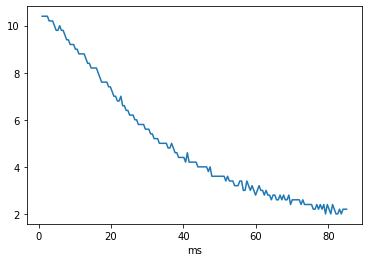

In [44]:
min_t = 1e-3
max_t = 85e-3
num = 175
arr = np.linspace(min_t,max_t,num)
hahn_times = arr*1e3
delay_time = 2

hahn_amps = []

def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e3
    return amp_integral


for tau in arr:
    hahn_exp(pi2_duration, pi_duration, tau)
    x,y = trace(delay_time)
    # echo_amplitude(x,y,tau,1)
    amp = echo_amplitude(x,y,tau,1)
    hahn_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")

plt.xlabel('ms')
plt.plot(hahn_times, hahn_amps)


In [45]:
t2_f = open('t2_4_15.txt', 'w')
for i in range(len(hahn_times)):
    t2_f.write(str(hahn_times[i])+','+str(hahn_amps[i])+'\n')
t2_f.close()


0       1.000000
1       1.482759
2       1.965517
3       2.448276
4       2.931034
         ...    
170    83.068966
171    83.551724
172    84.034483
173    84.517241
174    85.000000
Name: delays, Length: 175, dtype: float64


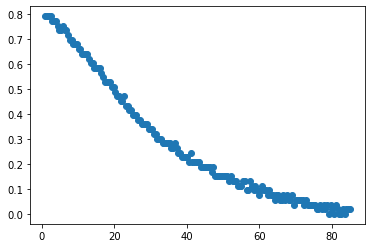

In [66]:
t2_f = pd.read_csv('t2_4_15.txt', header=None, names=["delays", 'amps', 'y2'])
# plt.plot(t2_f.delays, t2_f.amps)

t2_finaltimes = t2_f.delays
print(t2_finaltimes)
t2_finalamps = t2_f.amps
t2_finalamps /= normalization_const 
t2_finalamps -= np.min(t2_finalamps)
plt.scatter(t2_finaltimes, t2_finalamps)

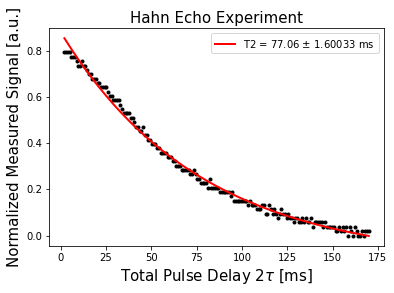

In [67]:
fit, err = curve_fit(exp_decay, t2_finaltimes*2, t2_finalamps, p0 = [2, 100, 2])
plt.scatter(t2_finaltimes*2, t2_finalamps, c= 'black', marker = '.')
plt.xlabel(f'Total Pulse Delay $2\\tau$ [ms]', fontsize = 15)
plt.ylabel('Normalized Measured Signal [a.u.]', fontsize = 15)
plt.plot(t2_finaltimes*2, exp_decay(t2_finaltimes*2, *fit), linewidth = 2, c = 'red', label = f'T2 = {fit[1]:.2f} $\pm$ {round(np.sqrt(err[1,1]),5)} ms')
plt.title('Hahn Echo Experiment', fontsize = 15)
plt.legend()
plt.show()

In [68]:
print('T2 Relaxation time: %.2f +- %.1e ms' % (fit[1], np.sqrt(err[1,1]))) 

T2 Relaxation time: 77.06 +- 1.6e+00 ms


CPMG Experiment:

In [51]:
def cpmg(pi_pulse, pi2_pulse, tau, num_pulses):
    # print('defining samples and binary')
    pi2_pulse_samples = int(pi2_pulse * SAMPLE_RATE)
    pi_pulse_samples = int(pi_pulse * SAMPLE_RATE)

    delay_nums = 100
    delay_unit = tau / delay_nums
    delay_unit_samples = int(delay_unit * SAMPLE_RATE)

    pi2_binary = np.ones(pi2_pulse_samples, dtype = int) * MAX
    pi_binary = np.ones(pi_pulse_samples, dtype = int) * MAX
    delay_binary = np.zeros(delay_unit_samples, dtype=int)
    # print('done')

    # print('Clearing volatile memory on AWG')
    awg.write("SOUR1:DATA:VOL:CLE")
    # print('done')

    # print('Writing Pi2_PULSE binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI2_PULSE, ', 
        pi2_binary, 
        datatype='i')
    # print('Done')

    # print('Writing Delay binary to AWG')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        delay_binary, 
        datatype='i')
    # print('done')

    # print('Writing Pi Pulse Binary')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_PULSE, ', 
        pi_binary, 
        datatype='i')
    # print('Done')
    
    sequence_command = f'CPMG,PI2_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,'
    for _ in range(num_pulses-1):
        sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,'
    sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'
    # print(sequence_command)
    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB CPMG')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')
    awg.write('OUTP2 OFF')

cpmg(pi_duration, pi2_duration, 10e-3, 4)

In [63]:
rabi_pulse(pi2_duration)

Delay 1.0ms, echo amplitude is 9.8
Delay 1.3288590604026846ms, echo amplitude is 9.8
Delay 1.657718120805369ms, echo amplitude is 9.8
Delay 1.9865771812080535ms, echo amplitude is 9.8
Delay 2.315436241610738ms, echo amplitude is 9.8
Delay 2.6442953020134228ms, echo amplitude is 9.4
Delay 2.9731543624161074ms, echo amplitude is 9.4
Delay 3.302013422818792ms, echo amplitude is 9.200000000000001
Delay 3.6308724832214767ms, echo amplitude is 9.4
Delay 3.9597315436241605ms, echo amplitude is 9.200000000000001
Delay 4.288590604026846ms, echo amplitude is 9.0
Delay 4.61744966442953ms, echo amplitude is 8.8
Delay 4.946308724832215ms, echo amplitude is 9.0
Delay 5.2751677852349ms, echo amplitude is 9.0
Delay 5.604026845637584ms, echo amplitude is 8.8
Delay 5.932885906040268ms, echo amplitude is 8.8
Delay 6.261744966442953ms, echo amplitude is 8.6
Delay 6.590604026845638ms, echo amplitude is 8.6
Delay 6.919463087248322ms, echo amplitude is 8.4
Delay 7.248322147651007ms, echo amplitude is 8.20000

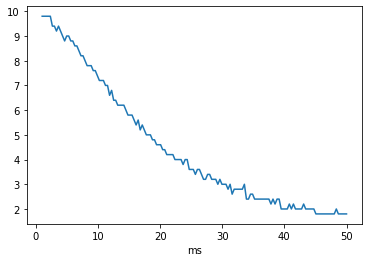

In [53]:
min_t = 1e-3
max_t = 50e-3
num = 150
arr = np.linspace(min_t,max_t,num)
cpmg_twotimes = arr*1e3
delay_time = 2


def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e3
    return amp_integral

cpmg_data = []
num_repeat = 2
two_peat_amps = []
for tau in arr:
    cpmg(pi_duration, pi2_duration, tau, num_repeat)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau,num_repeat)
    two_peat_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
cpmg_data.append(two_peat_amps)
plt.xlabel('ms')
plt.plot(cpmg_twotimes, two_peat_amps)
plt.show()

In [54]:
cpmg_f = open('cpmg_2peat_4_15.txt', 'w')
for i in range(num):
    cpmg_f.write(str(cpmg_twotimes[i]) + ',' + str(cpmg_data[0][i])+'\n')
cpmg_f.close()

#no drift

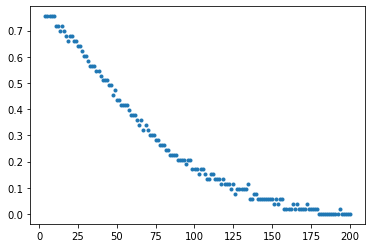

In [136]:
cpmg_f = pd.read_csv('cpmg_2peat_4_15.txt', header=None, names=["delays", 'twopeat'])

cpmg_two_final_times = (4)*cpmg_f.delays
cpmg_two_final_amps = cpmg_f.twopeat
cpmg_two_final_amps/=normalization_const
cpmg_two_final_amps -= np.min(cpmg_two_final_amps)
plt.scatter(cpmg_two_final_times, cpmg_two_final_amps, marker = '.')

Delay 1.0ms, echo amplitude is 6.800000000000001
Delay 1.2281879194630871ms, echo amplitude is 7.0
Delay 1.4563758389261745ms, echo amplitude is 7.4
Delay 1.6845637583892619ms, echo amplitude is 7.0
Delay 1.9127516778523492ms, echo amplitude is 7.0
Delay 2.1409395973154366ms, echo amplitude is 7.2
Delay 2.3691275167785237ms, echo amplitude is 7.2
Delay 2.597315436241611ms, echo amplitude is 6.800000000000001
Delay 2.8255033557046985ms, echo amplitude is 6.6000000000000005
Delay 3.0536912751677856ms, echo amplitude is 7.2
Delay 3.2818791946308727ms, echo amplitude is 6.800000000000001
Delay 3.51006711409396ms, echo amplitude is 6.800000000000001
Delay 3.738255033557047ms, echo amplitude is 6.6000000000000005
Delay 3.9664429530201337ms, echo amplitude is 6.4
Delay 4.194630872483223ms, echo amplitude is 6.4
Delay 4.422818791946309ms, echo amplitude is 6.6000000000000005
Delay 4.651006711409396ms, echo amplitude is 6.4
Delay 4.879194630872483ms, echo amplitude is 6.2
Delay 5.10738255033557

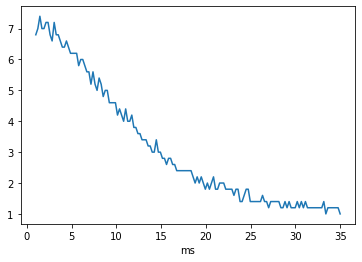

In [59]:
num_repeat = 4
four_peat_amps = []
delay_time = 2
min_t = 1e-3
max_t = 35e-3
arr = np.linspace(min_t,max_t,num)
cpmg_fourtimes = arr*1e3
for tau in arr:
    cpmg(pi_duration, pi2_duration, tau, num_repeat)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau,num_repeat)
    four_peat_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
# cpmg_data.append(four_peat_amps)
plt.xlabel('ms')
plt.plot(cpmg_fourtimes, four_peat_amps)
plt.show()


In [60]:
cpmg_f = open('cpmg_4peat_4_15.txt', 'w')
for i in range(num):
    cpmg_f.write(str(cpmg_fourtimes[i]) + ',' + str(four_peat_amps[i])+'\n')
cpmg_f.close()
#Drift from 21.37156MHz to 21.37164MHz

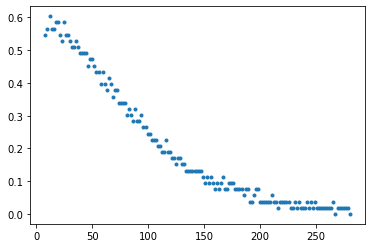

In [137]:
cpmg_f = pd.read_csv('cpmg_4peat_4_15.txt', header=None, names=["delays", 'fourpeat'])

cpmg_four_final_times = (8)*cpmg_f.delays
# print(cpmg_four_final_times[5]/(2+2*num_repeat), cpmg_four_final_times[num-11-5]/(2+2*num_repeat))
cpmg_four_final_amps = cpmg_f.fourpeat
cpmg_four_final_amps/=normalization_const
cpmg_four_final_amps -= np.min(cpmg_four_final_amps)
plt.scatter(cpmg_four_final_times, cpmg_four_final_amps, marker = '.')

In [62]:
cpmg(pi_duration, pi2_duration, 1e-3, 8)

Delay 1.0ms, echo amplitude is 4.6000000000000005
Delay 1.1091954022988506ms, echo amplitude is 5.0
Delay 1.2183908045977012ms, echo amplitude is 4.6000000000000005
Delay 1.3275862068965518ms, echo amplitude is 4.6000000000000005
Delay 1.4367816091954022ms, echo amplitude is 4.800000000000001
Delay 1.545977011494253ms, echo amplitude is 4.6000000000000005
Delay 1.6551724137931034ms, echo amplitude is 5.0
Delay 1.7643678160919543ms, echo amplitude is 5.0
Delay 1.8735632183908046ms, echo amplitude is 5.0
Delay 1.9827586206896552ms, echo amplitude is 5.0
Delay 2.091954022988506ms, echo amplitude is 5.0
Delay 2.2011494252873565ms, echo amplitude is 5.0
Delay 2.310344827586207ms, echo amplitude is 4.800000000000001
Delay 2.4195402298850577ms, echo amplitude is 4.6000000000000005
Delay 2.5287356321839085ms, echo amplitude is 4.6000000000000005
Delay 2.637931034482759ms, echo amplitude is 4.800000000000001
Delay 2.747126436781609ms, echo amplitude is 4.6000000000000005
Delay 2.856321839080459

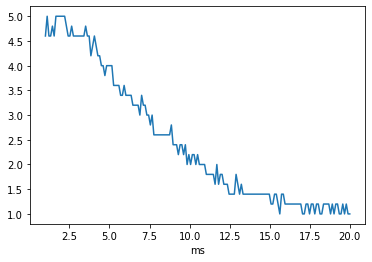

In [71]:
eight_peat_amps = []
num_repeat = 8
delay_time = 2
num = 175
min_t = 1e-3
max_t = 20e-3
arr = np.linspace(min_t,max_t,num)
cpmg_eighttimes = arr*1e3
for tau in arr:
    cpmg(pi_duration, pi2_duration, tau, num_repeat)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau,num_repeat)
    eight_peat_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
cpmg_data.append(eight_peat_amps)
plt.xlabel('ms')
plt.plot(cpmg_eighttimes, eight_peat_amps)
plt.show()

In [117]:
cpmg_f = open('cpmg_8peat_4_15.txt', 'w')
for i in range(num-2):
    cpmg_f.write(str(cpmg_eighttimes[i]) + ',' + str(eight_peat_amps[i])+'\n')
cpmg_f.close()
#Drift from 21.37164MHz to 21.37168MHz

IndexError: index 175 is out of bounds for axis 0 with size 175

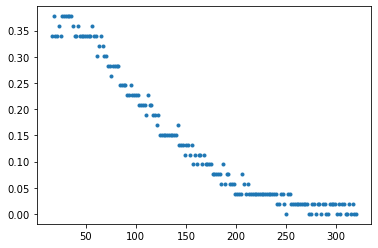

In [138]:
cpmg_f = pd.read_csv('cpmg_8peat_4_15.txt', header=None, names=["delays", 'eightpeat'])

cpmg_eight_final_times = (16)*cpmg_f.delays
cpmg_eight_final_amps = cpmg_f.eightpeat
cpmg_eight_final_amps/=normalization_const
cpmg_eight_final_amps -= np.min(cpmg_eight_final_amps)
plt.scatter(cpmg_eight_final_times, cpmg_eight_final_amps, marker = '.')

Delay 1.0ms, echo amplitude is 3.2
Delay 1.07035175879397ms, echo amplitude is 3.0
Delay 1.1407035175879399ms, echo amplitude is 2.8000000000000003
Delay 1.2110552763819096ms, echo amplitude is 2.6
Delay 1.2814070351758793ms, echo amplitude is 2.8000000000000003
Delay 1.3517587939698492ms, echo amplitude is 2.6
Delay 1.422110552763819ms, echo amplitude is 2.6
Delay 1.4924623115577889ms, echo amplitude is 2.6
Delay 1.5628140703517588ms, echo amplitude is 2.4000000000000004
Delay 1.6331658291457287ms, echo amplitude is 2.6
Delay 1.7035175879396984ms, echo amplitude is 2.6
Delay 1.7738693467336681ms, echo amplitude is 2.4000000000000004
Delay 1.844221105527638ms, echo amplitude is 2.4000000000000004
Delay 1.914572864321608ms, echo amplitude is 2.4000000000000004
Delay 1.9849246231155777ms, echo amplitude is 2.4000000000000004
Delay 2.055276381909547ms, echo amplitude is 2.4000000000000004
Delay 2.1256281407035176ms, echo amplitude is 2.4000000000000004
Delay 2.1959798994974875ms, echo amp

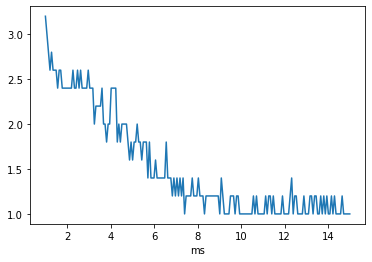

In [81]:
sixteen_peat_amps = []
num_repeat = 16
num = 200
delay_time = 3
min_t = 1e-3
max_t = 15e-3
arr = np.linspace(min_t,max_t,num)
cpmg_sixteentimes = arr*1e3
for tau in arr:
    cpmg(pi_duration, pi2_duration, tau, num_repeat)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau,num_repeat)
    sixteen_peat_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
# cpmg_data.append(sixteen_peat_amps)
plt.xlabel('ms')
plt.plot(cpmg_sixteentimes, sixteen_peat_amps)
plt.show()

In [82]:
cpmg_f = open('cpmg_16peat_4_15.txt', 'w')
for i in range(num-1):
    cpmg_f.write(str(cpmg_sixteentimes[i]) + ',' + str(sixteen_peat_amps[i])+'\n')
cpmg_f.close()

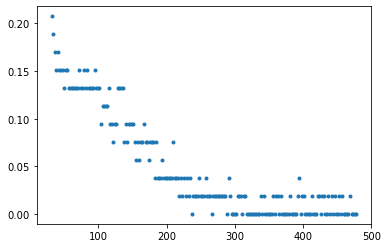

In [139]:
cpmg_f = pd.read_csv('cpmg_16peat_4_15.txt', header=None, names=["delays", 'sixteenpeat'])

cpmg_sixteen_final_times = (32)*cpmg_f.delays
cpmg_sixteen_final_amps = cpmg_f.sixteenpeat
cpmg_sixteen_final_amps /=normalization_const
cpmg_sixteen_final_amps -= np.min(cpmg_sixteen_final_amps)
plt.scatter(cpmg_sixteen_final_times, cpmg_sixteen_final_amps, marker = '.')

Fitting CPMG

In [84]:
def n_pulse_dec(x, A, n, T, C):
    return A*np.exp(-(x/T)**n) + C

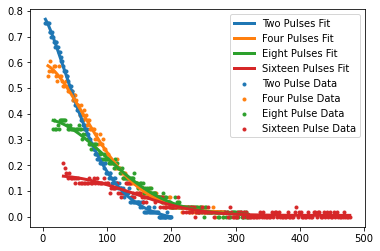

In [140]:
fit2, err2 = curve_fit(n_pulse_dec, cpmg_two_final_times, cpmg_two_final_amps, p0 = [2, 1, 100, 0.1])
fit4, err4 = curve_fit(n_pulse_dec, cpmg_four_final_times, cpmg_four_final_amps, p0 = [2, 1, 100, 0.1])
fit8, err8 = curve_fit(n_pulse_dec, cpmg_eight_final_times, cpmg_eight_final_amps, p0 = [2, 1, 100, 0.1])
fit16, err16 = curve_fit(n_pulse_dec, cpmg_sixteen_final_times, cpmg_sixteen_final_amps, p0 = [2, 1, 100, 0.1])

finer_times = np.linspace(1, 700, 10000)
plt.scatter(cpmg_two_final_times, cpmg_two_final_amps, marker = '.', label = 'Two Pulse Data')
plt.scatter(cpmg_four_final_times, cpmg_four_final_amps, marker = '.', label = 'Four Pulse Data')
plt.scatter(cpmg_eight_final_times, cpmg_eight_final_amps, marker = '.', label = 'Eight Pulse Data')
plt.scatter(cpmg_sixteen_final_times, cpmg_sixteen_final_amps, marker = '.', label = 'Sixteen Pulse Data')
plt.plot(cpmg_two_final_times, n_pulse_dec(cpmg_two_final_times, *fit2), label = 'Two Pulses Fit', linewidth = 3)
plt.plot(cpmg_four_final_times, n_pulse_dec(cpmg_four_final_times, *fit4), label = 'Four Pulses Fit', linewidth = 3)
plt.plot(cpmg_eight_final_times, n_pulse_dec(cpmg_eight_final_times, *fit8), label = 'Eight Pulses Fit', linewidth = 3)
plt.plot(cpmg_sixteen_final_times, n_pulse_dec(cpmg_sixteen_final_times, *fit16), label = 'Sixteen Pulses Fit', linewidth = 3)
plt.legend()


In [141]:
print(fit2[2], fit4[2], fit8[2], fit16[2])

78.27468417042148 106.24455844644487 139.01229196667518 175.7624037197465


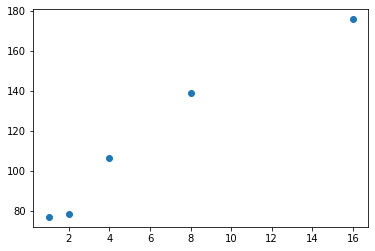

In [142]:
plt.scatter([1,2,4,8,16], [fit[1], fit2[2], fit4[2], fit8[2], fit16[2]])

In [144]:
print('T2 Relaxation time for CPMG2: %.2f +- %.1e ms' % (fit2[2], np.sqrt(err2[2,2]))) 
print('T2 Relaxation time for CPMG4: %.2f +- %.1e ms' % (fit4[2], np.sqrt(err4[2,2]))) 
print('T2 Relaxation time for CPMG8: %.2f +- %.1e ms' % (fit8[2], np.sqrt(err8[2,2]))) 
print('T2 Relaxation time for CPMG16: %.2f +- %.1e ms' % (fit16[2], np.sqrt(err16[2,2]))) 

print('n Exponent for CPMG2: %.2f +- %.1e' % (fit2[1], np.sqrt(err2[1,1]))) 
print('n Exponent for CPMG4: %.2f +- %.1e' % (fit4[1], np.sqrt(err4[1,1]))) 
print('n Exponent for CPMG8: %.2f +- %.1e' % (fit8[1], np.sqrt(err8[1,1]))) 
print('n Exponent for CPMG16: %.2f +- %.1e' % (fit16[1], np.sqrt(err16[1,1]))) 

T2 Relaxation time for CPMG2: 78.27 +- 6.3e-01 ms
T2 Relaxation time for CPMG4: 106.24 +- 1.0e+00 ms
T2 Relaxation time for CPMG8: 139.01 +- 1.5e+00 ms
T2 Relaxation time for CPMG16: 175.76 +- 3.7e+00 ms
n Exponent for CPMG2: 1.40 +- 2.4e-02
n Exponent for CPMG4: 1.69 +- 4.2e-02
n Exponent for CPMG8: 1.99 +- 6.6e-02
n Exponent for CPMG16: 2.36 +- 1.7e-01


XY-N Experiment

In [89]:
def xyn_exp(pi2_pulse, pi_pulse, num_pulses, tau):
    # print('defining samples and binary')
    pi2_pulse_samples = int(pi2_pulse * SAMPLE_RATE)
    pi_pulse_samples = int(pi_pulse * SAMPLE_RATE)

    delay_nums = 100
    delay_unit = tau / delay_nums
    delay_unit_samples = int(delay_unit * SAMPLE_RATE)

    pi2_binary = np.ones(pi2_pulse_samples, dtype = int) * MAX
    pi_binary = np.ones(pi_pulse_samples, dtype = int) * MAX
    delay_binary = np.zeros(delay_unit_samples, dtype=int)

    delay_unit1 = (tau + pi2_pulse)/delay_nums
    delay_unit2 = (tau + pi_pulse)/delay_nums
    delay_unitpi2_samples = int(delay_unit1*SAMPLE_RATE)
    delay_unitpi_samples = int(delay_unit2*SAMPLE_RATE)

    delaypi2_binary = np.zeros(delay_unitpi2_samples, dtype = int)
    delaypi_binary = np.zeros(delay_unitpi_samples, dtype = int)
    # print('done')

    # print('Clearing volatile memory on AWG')
    awg.write("SOUR1:DATA:VOL:CLE")
    awg.write("SOUR2:DATA:VOL:CLE")

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI2_PULSE, ', 
        pi2_binary, 
        datatype='i')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_PULSE, ', 
        pi_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR2:DATA:ARB:DAC PI_PULSE, ', 
        pi_binary, 
        datatype='i')

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        delay_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR2:DATA:ARB:DAC DELAY, ', 
        delay_binary, 
        datatype='i')
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY_PI, ', 
        delaypi_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR2:DATA:ARB:DAC DELAY_PI2, ', 
        delaypi2_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR2:DATA:ARB:DAC DELAY_PI, ', 
        delaypi_binary, 
        datatype='i')
    
   
    # print('Done')
    
    channel1_sequence_command = f'XN,PI2_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,'
    channel2_sequence_command = f'YN,DELAY_PI2,{delay_nums},repeat,lowAtStart,0,DELAY_PI,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,'
    for _ in range(num_pulses-1):
        channel1_sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY_PI,{delay_nums},repeat,lowAtStart,0,'
        channel2_sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY_PI,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,'
    channel1_sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'
    channel2_sequence_command += f'PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'

    
    channel1_sequence_length = len(channel1_sequence_command.encode('ascii'))
    channel2_sequence_length = len(channel2_sequence_command.encode('ascii'))
    channel1_full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(channel1_sequence_length))}{channel1_sequence_length}" + channel1_sequence_command
    channel2_full_sequence_command = f"SOUR2:DATA:SEQ #{len(str(channel2_sequence_length))}{channel2_sequence_length}" + channel2_sequence_command

    awg.write(channel1_full_sequence_command)
    awg.write(channel2_full_sequence_command)


    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB XN')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('SOUR2:FUNC:ARB YN')
    awg.write(f'SOUR2:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')
    awg.write('OUTP2 ON')

xyn_exp(pi2_duration, pi_duration, 2, 5e-3)

In [95]:
min_t = 1e-3
max_t = 50e-3
num = 150
arr = np.linspace(min_t,max_t,num)
xyn_onetimes = arr*1e3
delay_time = 2


def integral(x, y):
    amp_integral = 0
    for i in range(1, len(y)):
        amp_integral += y[i]*(x[i] - x[i-1])*1e3
    return amp_integral

xyn_data = []
num_repeat = 1
one_amps = []
for tau in arr:
    xyn_exp(pi2_duration, pi_duration, num_repeat, tau)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau, 2*num_repeat)
    one_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
xyn_data.append(one_amps)
plt.xlabel('ms')
plt.plot(xyn_onetimes, one_amps)
plt.show()

Delay 1.0ms, echo amplitude is 5.4
Delay 1.3288590604026846ms, echo amplitude is 4.4
Delay 1.657718120805369ms, echo amplitude is 4.2
Delay 1.9865771812080535ms, echo amplitude is 3.4000000000000004
Delay 2.315436241610738ms, echo amplitude is 3.0
Delay 2.6442953020134228ms, echo amplitude is 2.8000000000000003
Delay 2.9731543624161074ms, echo amplitude is 2.6
Delay 3.302013422818792ms, echo amplitude is 2.4000000000000004
Delay 3.6308724832214767ms, echo amplitude is 2.4000000000000004
Delay 3.9597315436241605ms, echo amplitude is 2.0
Delay 4.288590604026846ms, echo amplitude is 1.8
Delay 4.61744966442953ms, echo amplitude is 1.6
Delay 4.946308724832215ms, echo amplitude is 1.8
Delay 5.2751677852349ms, echo amplitude is 1.4000000000000001
Delay 5.604026845637584ms, echo amplitude is 1.4000000000000001


KeyboardInterrupt: 

In [91]:
xy_f = open('XY1Final.txt', 'w')
for i in range(num):
    xy_f.write(str(xyn_onetimes[i]) + ',' + str(xyn_data[0][i])+'\n')
xy_f.close()

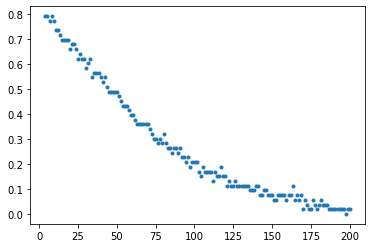

In [149]:
xy_f = pd.read_csv('XY1Final.txt', header=None, names=["delays", 'once'])

xy_one_final_times = (4)*xy_f.delays
xy_one_final_amps = xy_f.once
xy_one_final_amps/=normalization_const
xy_one_final_amps -= np.min(xy_one_final_amps)
plt.scatter(xy_one_final_times, xy_one_final_amps, marker = '.')

Delay 1.0ms, echo amplitude is 9.8
Delay 1.2281879194630871ms, echo amplitude is 9.8
Delay 1.4563758389261745ms, echo amplitude is 9.8
Delay 1.6845637583892619ms, echo amplitude is 9.600000000000001
Delay 1.9127516778523492ms, echo amplitude is 9.200000000000001
Delay 2.1409395973154366ms, echo amplitude is 9.200000000000001
Delay 2.3691275167785237ms, echo amplitude is 9.4
Delay 2.597315436241611ms, echo amplitude is 9.0
Delay 2.8255033557046985ms, echo amplitude is 9.4
Delay 3.0536912751677856ms, echo amplitude is 9.0
Delay 3.2818791946308727ms, echo amplitude is 8.4
Delay 3.51006711409396ms, echo amplitude is 8.8
Delay 3.738255033557047ms, echo amplitude is 8.4
Delay 3.9664429530201337ms, echo amplitude is 8.6
Delay 4.194630872483223ms, echo amplitude is 8.4
Delay 4.422818791946309ms, echo amplitude is 8.200000000000001
Delay 4.651006711409396ms, echo amplitude is 8.6
Delay 4.879194630872483ms, echo amplitude is 8.200000000000001
Delay 5.107382550335571ms, echo amplitude is 8.200000

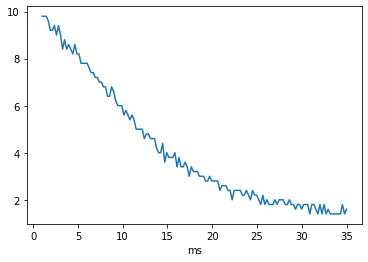

In [96]:
min_t = 1e-3
max_t = 35e-3
num = 150
arr = np.linspace(min_t,max_t,num)
xyn_twotimes = arr*1e3
delay_time = 2

num_repeat = 2
two_amps = []
for tau in arr:
    xyn_exp(pi2_duration, pi_duration, num_repeat, tau)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau, 2*num_repeat)
    two_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
xyn_data.append(two_amps)
plt.xlabel('ms')
plt.plot(xyn_twotimes, two_amps)
plt.show()

[9.8,
 9.8,
 9.8,
 9.600000000000001,
 9.200000000000001,
 9.200000000000001,
 9.4,
 9.0,
 9.4,
 9.0,
 8.4,
 8.8,
 8.4,
 8.6,
 8.4,
 8.200000000000001,
 8.6,
 8.200000000000001,
 8.200000000000001,
 7.800000000000001,
 7.800000000000001,
 7.800000000000001,
 7.800000000000001,
 7.6000000000000005,
 7.4,
 7.4,
 7.2,
 7.2,
 7.0,
 7.0,
 6.800000000000001,
 6.800000000000001,
 6.4,
 6.4,
 6.800000000000001,
 6.6000000000000005,
 6.2,
 6.0,
 6.0,
 6.0,
 5.6000000000000005,
 5.800000000000001,
 5.6000000000000005,
 5.4,
 5.6000000000000005,
 5.4,
 5.0,
 5.0,
 5.0,
 5.0,
 4.6000000000000005,
 4.800000000000001,
 4.800000000000001,
 4.6000000000000005,
 4.6000000000000005,
 4.6000000000000005,
 4.2,
 4.0,
 4.0,
 4.4,
 3.6,
 4.0,
 3.8000000000000003,
 3.8000000000000003,
 3.8000000000000003,
 4.0,
 3.4000000000000004,
 3.8000000000000003,
 3.4000000000000004,
 3.4000000000000004,
 3.6,
 3.4000000000000004,
 3.0,
 3.4000000000000004,
 3.2,
 3.2,
 3.2,
 3.0,
 3.0,
 3.0,
 2.8000000000000003,
 2.80

In [100]:
xy_f = open('XY2Final.txt', 'w')
for i in range(num):
    xy_f.write(str(xyn_twotimes[i]) + ',' + str(two_amps[i])+'\n')
xy_f.close()

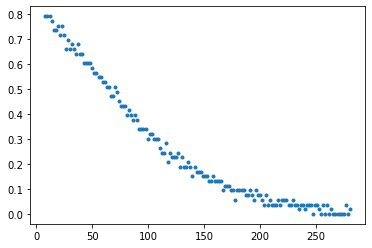

In [146]:
xy_f = pd.read_csv('XY2Final.txt', header=None, names=["delays", 'twice'])

xy_two_final_times = (8)*xy_f.delays
xy_two_final_amps = xy_f.twice
xy_two_final_amps/=normalization_const
xy_two_final_amps -= np.min(xy_two_final_amps)
plt.scatter(xy_two_final_times, xy_two_final_amps, marker = '.')

Delay 1.0ms, echo amplitude is 9.4
Delay 1.1091954022988506ms, echo amplitude is 9.200000000000001
Delay 1.2183908045977012ms, echo amplitude is 9.200000000000001
Delay 1.3275862068965518ms, echo amplitude is 9.0
Delay 1.4367816091954022ms, echo amplitude is 8.8
Delay 1.545977011494253ms, echo amplitude is 8.8
Delay 1.6551724137931034ms, echo amplitude is 8.8
Delay 1.7643678160919543ms, echo amplitude is 8.6
Delay 1.8735632183908046ms, echo amplitude is 8.8
Delay 1.9827586206896552ms, echo amplitude is 8.4
Delay 2.091954022988506ms, echo amplitude is 8.4
Delay 2.2011494252873565ms, echo amplitude is 8.200000000000001
Delay 2.310344827586207ms, echo amplitude is 8.200000000000001
Delay 2.4195402298850577ms, echo amplitude is 8.200000000000001
Delay 2.5287356321839085ms, echo amplitude is 8.0
Delay 2.637931034482759ms, echo amplitude is 8.0
Delay 2.747126436781609ms, echo amplitude is 8.200000000000001
Delay 2.8563218390804597ms, echo amplitude is 7.800000000000001
Delay 2.96551724137931

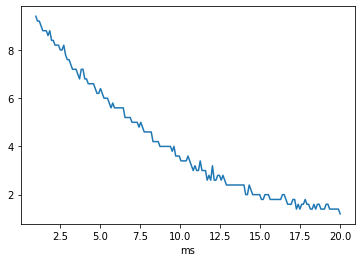

In [102]:
min_t = 1e-3
max_t = 20e-3
num = 175
arr = np.linspace(min_t,max_t,num)
xyn_fourtimes = arr*1e3
delay_time = 2.5

num_repeat = 4
four_amps = []
for tau in arr:
    xyn_exp(pi2_duration, pi_duration, num_repeat, tau)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau, 2*num_repeat)
    four_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
xyn_data.append(four_amps)
plt.xlabel('ms')
plt.plot(xyn_fourtimes, four_amps)
plt.show()

In [103]:
xy_f = open('XY4Final.txt', 'w')
for i in range(num):
    xy_f.write(str(xyn_fourtimes[i]) + ',' + str(four_amps[i])+'\n')
xy_f.close()

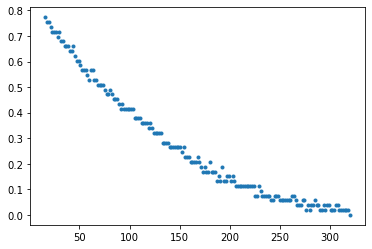

In [154]:
xy_f = pd.read_csv('XY4Final.txt', header=None, names=["delays", 'four'])

xy_four_final_times = (16)*xy_f.delays
xy_four_final_amps = xy_f.four
xy_four_final_amps/=normalization_const
xy_four_final_amps -= np.min(xy_four_final_amps)
plt.scatter(xy_four_final_times, xy_four_final_amps, marker = '.')

Delay 1.0ms, echo amplitude is 7.2
Delay 1.07035175879397ms, echo amplitude is 7.4
Delay 1.1407035175879399ms, echo amplitude is 7.2
Delay 1.2110552763819096ms, echo amplitude is 7.2
Delay 1.2814070351758793ms, echo amplitude is 7.0
Delay 1.3517587939698492ms, echo amplitude is 7.2
Delay 1.422110552763819ms, echo amplitude is 6.800000000000001
Delay 1.4924623115577889ms, echo amplitude is 7.2
Delay 1.5628140703517588ms, echo amplitude is 6.800000000000001
Delay 1.6331658291457287ms, echo amplitude is 6.4
Delay 1.7035175879396984ms, echo amplitude is 6.6000000000000005
Delay 1.7738693467336681ms, echo amplitude is 6.2
Delay 1.844221105527638ms, echo amplitude is 6.0
Delay 1.914572864321608ms, echo amplitude is 6.4
Delay 1.9849246231155777ms, echo amplitude is 6.2
Delay 2.055276381909547ms, echo amplitude is 6.2
Delay 2.1256281407035176ms, echo amplitude is 5.2
Delay 2.1959798994974875ms, echo amplitude is 6.0
Delay 2.2663316582914574ms, echo amplitude is 5.800000000000001
Delay 2.336683

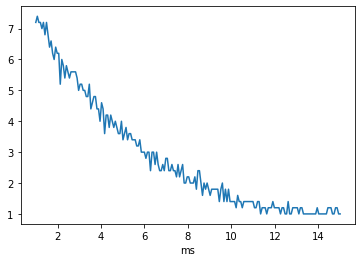

In [106]:
min_t = 1e-3
max_t = 15e-3
num = 200
arr = np.linspace(min_t,max_t,num)
xyn_eighttimes = arr*1e3
delay_time = 2.5

num_repeat = 8
eight_amps = []
for tau in arr:
    xyn_exp(pi2_duration, pi_duration, num_repeat, tau)
    x,y = trace(delay_time)
    amp = echo_amplitude(x,y,tau, 2*num_repeat)
    eight_amps.append(amp)
    print(f"Delay {tau*1e3}ms, echo amplitude is {amp}")
print(f'Experiment Done for {num_repeat} pulses')
xyn_data.append(eight_amps)
plt.xlabel('ms')
plt.plot(xyn_eighttimes, eight_amps)
plt.show()

In [107]:
xy_f = open('XY8Final.txt', 'w')
for i in range(num):
    xy_f.write(str(xyn_eighttimes[i]) + ',' + str(eight_amps[i])+'\n')
xy_f.close()

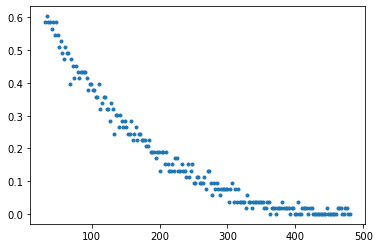

In [152]:
xy_f = pd.read_csv('XY8Final.txt', header=None, names=["delays", 'eight'])

xy_eight_final_times = (32)*xy_f.delays
xy_eight_final_amps = xy_f.eight
xy_eight_final_amps/=normalization_const
xy_eight_final_amps -= np.min(xy_eight_final_amps)
plt.scatter(xy_eight_final_times, xy_eight_final_amps, marker = '.')

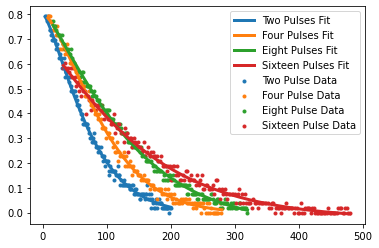

In [155]:
fit2, err2 = curve_fit(n_pulse_dec, xy_one_final_times, xy_one_final_amps, p0 = [2, 1, 100, 0.1])
fit4, err4 = curve_fit(n_pulse_dec, xy_two_final_times, xy_two_final_amps, p0 = [2, 1, 100, 0.1])
fit8, err8 = curve_fit(n_pulse_dec, xy_four_final_times, xy_four_final_amps, p0 = [2, 1, 100, 0.1])
fit16, err16 = curve_fit(n_pulse_dec, xy_eight_final_times, xy_eight_final_amps, p0 = [2, 1, 100, 0.1])

finer_times = np.linspace(1, 700, 10000)
plt.scatter(xy_one_final_times, xy_one_final_amps, marker = '.', label = 'Two Pulse Data')
plt.scatter(xy_two_final_times, xy_two_final_amps, marker = '.', label = 'Four Pulse Data')
plt.scatter(xy_four_final_times, xy_four_final_amps, marker = '.', label = 'Eight Pulse Data')
plt.scatter(xy_eight_final_times, xy_eight_final_amps, marker = '.', label = 'Sixteen Pulse Data')
plt.plot(xy_one_final_times, n_pulse_dec(xy_one_final_times, *fit2), label = 'Two Pulses Fit', linewidth = 3)
plt.plot(xy_two_final_times, n_pulse_dec(xy_two_final_times, *fit4), label = 'Four Pulses Fit', linewidth = 3)
plt.plot(xy_four_final_times, n_pulse_dec(xy_four_final_times, *fit8), label = 'Eight Pulses Fit', linewidth = 3)
plt.plot(xy_eight_final_times, n_pulse_dec(xy_eight_final_times, *fit16), label = 'Sixteen Pulses Fit', linewidth = 3)
plt.legend()

In [156]:
print(fit2[2], fit4[2], fit8[2], fit16[2])

79.3139643147727 106.74030200172396 141.99694807174978 164.55235398764012


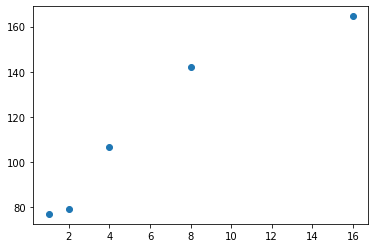

In [157]:
plt.scatter([1,2,4,8,16], [fit[1], fit2[2], fit4[2], fit8[2], fit16[2]])

In [158]:
print('T2 Relaxation time for XY2: %.2f +- %.1e ms' % (fit2[2], np.sqrt(err2[2,2]))) 
print('T2 Relaxation time for XY4: %.2f +- %.1e ms' % (fit4[2], np.sqrt(err4[2,2]))) 
print('T2 Relaxation time for XY8: %.2f +- %.1e ms' % (fit8[2], np.sqrt(err8[2,2]))) 
print('T2 Relaxation time for XY16: %.2f +- %.1e ms' % (fit16[2], np.sqrt(err16[2,2]))) 

print('n Exponent for XY2: %.2f +- %.1e' % (fit2[1], np.sqrt(err2[1,1]))) 
print('n Exponent for XY4: %.2f +- %.1e' % (fit4[1], np.sqrt(err4[1,1]))) 
print('n Exponent for XY8: %.2f +- %.1e' % (fit8[1], np.sqrt(err8[1,1]))) 
print('n Exponent for XY16: %.2f +- %.1e' % (fit16[1], np.sqrt(err16[1,1]))) 

T2 Relaxation time for XY2: 79.31 +- 1.0e+00 ms
T2 Relaxation time for XY4: 106.74 +- 1.1e+00 ms
T2 Relaxation time for XY8: 142.00 +- 2.0e+00 ms
T2 Relaxation time for XY16: 164.55 +- 3.4e+00 ms
n Exponent for XY2: 1.32 +- 3.5e-02
n Exponent for XY4: 1.48 +- 3.5e-02
n Exponent for XY8: 1.23 +- 3.6e-02
n Exponent for XY16: 1.18 +- 5.8e-02


The above example should be readily applicable to the Hahn Echo sequence. Writing other pulse sequeces such as Rabi, T1, and CPMG. To change the phase, for XY-N pulses, one can modify the pulse amplitude at the start of the pulse to reflect the chosen phase. Here, we use np.ones to set the pulse shape to square, but you'll need to adjust that to reflect the 90 degree phase shift between the two pulses

Another somewhat simpler implementation for a single pulse sequeunce is below:

In [12]:
def PULSE_A():
    waveform = np.pad(np.ones(PULSE_A_SAMPLES).astype(int) * MAX, pad_width=(0, 50))
    
    awg.write('SOUR1:DATA:VOL:CLE')

    awg.write_binary_values('SOUR1:DATA:ARB:DAC PULSE_A, ', waveform, datatype='i')
    
    awg.write('SOUR1:FUNC:ARB PULSE_A')
    awg.write('SOUR1:VOLT 4')
    awg.write('OUTP1 ON')

Also useful to be able to communicate with the scope to extract information from it. 
A simple way to get a value from the scope is below, where you are using the measurement functionality of the scope. Important would be set the correct point for the scope to measure, since the position of echo depends on precession time, pulse number, etc, from the last trigger.

In [17]:
scope.write('MEASUrement:MEAS1:STATE ON')

time.sleep(1) #Time the scope is in the measurement state, in units of seconds.

mean = float(scope.query('MEASUrement:MEAS1:MEAN?'))
count = int(scope.query('MEASUrement:MEAS1:COUNt?'))
std = float(scope.query('MEASUrement:MEAS1:STDdev?'))

scope.write('MEASUrement:MEAS1:STATE OFF')

#return mean, count, std
print(mean, count, std)

1.8285 2677 0.0923579


Perhaps more easily, you can also extract all the whole oscilloscope trace. Note that you will need to trigger the oscillscope to properly extract the trace containining your data, this can be contained within the AWG sequence command.  You can then analyze those traces yourself. 

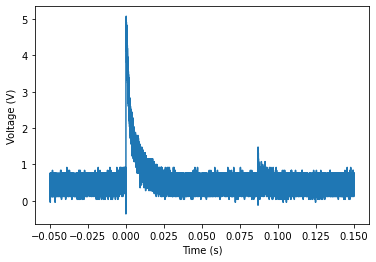

(array([-0.05    , -0.049998, -0.049996, ...,  0.149994,  0.149996,
         0.149998]),
 array([0.6 , 0.04, 0.36, ..., 0.36, 0.44, 0.44]))

In [73]:
trace(1)
